Requirements

In [1]:
!pip install insightface onnxruntime onnxruntime-gpu opencv-python-headless

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055393 sha256=5d0ee3e3b16218fe791095646cdd7610cba208cde519e19de38f4a2f8dca456b
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [2]:
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 24.5 MB/s eta 0:00:00
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.19
    Uninstalling albucore-0.0.19:
      Successfully uninstalled albucore-0.0.19
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20


Name convention consistency

In [3]:
import os
import cv2
import pandas as pd
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import files
import shutil

# Step 1: Setup Directories
video_dir = "/content/videos/"
frame_dir = "/content/frames/"
os.makedirs(video_dir, exist_ok=True)
os.makedirs(frame_dir, exist_ok=True)

# Step 2: Load Data
def load_data():
    """
    Uploads and loads the CSV file into a DataFrame.

    Returns:
        DataFrame: Cleaned data with video URLs and performance metrics.
    """
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    data = pd.read_csv(file_name)
    data_cleaned = data.drop_duplicates(subset="Video URL").reset_index(drop=True)
    return data_cleaned

# Step 3: Download Videos
def download_video(video_url, save_dir):
    """
    Downloads a video from the given URL and saves it in the specified directory.

    Args:
        video_url (str): URL of the video to download.
        save_dir (str): Directory to save the video.

    Returns:
        str: Path to the downloaded video.
    """
    video_name = os.path.basename(video_url)
    video_path = os.path.join(save_dir, video_name)
    os.system(f"wget -q -O {video_path} {video_url}")
    return video_path

# Step 4: Extract Faces and Save with Unified Naming
def extract_faces_from_video(video_path, video_name, output_dir):
    """
    Extracts unique faces from a video and saves them with a unified naming convention.

    Args:
        video_path (str): Path to the video file.
        video_name (str): Base name of the video file (used for naming images).
        output_dir (str): Directory to save face images.

    Returns:
        list: List of unique face embeddings found in the video.
    """
    app = FaceAnalysis(allowed_modules=['detection', 'recognition'])
    app.prepare(ctx_id=0, det_thresh=0.5)  # Use GPU if available, else CPU

    cap = cv2.VideoCapture(video_path)
    face_embeddings = []
    frame_count = 0
    skipped_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process every 10th frame
        if frame_count % 10 == 0:
            try:
                faces = app.get(frame)
                for face in faces:
                    embedding = face.normed_embedding

                    # Check for unique face using cosine similarity
                    is_unique = True
                    for existing_embedding in face_embeddings:
                        similarity = cosine_similarity([embedding], [existing_embedding])[0][0]
                        if similarity > 0.85:  # Threshold for uniqueness
                            is_unique = False
                            break

                    if is_unique:
                        face_embeddings.append(embedding)

                        # Save face image with video name in filename
                        file_name = f"face_{len(face_embeddings)}_{video_name}.jpg"
                        face_path = os.path.join(output_dir, file_name)

                        x1, y1, x2, y2 = [int(v) for v in face.bbox]
                        face_image = frame[y1:y2, x1:x2]
                        if face_image.size > 0:
                            cv2.imwrite(face_path, face_image)

            except Exception as e:
                print(f"Error processing frame {frame_count}: {e}")
                skipped_frames += 1

        frame_count += 1

    cap.release()
    print(f"Skipped frames in {os.path.basename(video_path)}: {skipped_frames}")
    return face_embeddings

# Step 5: Process Videos and Link Faces to Performance
def process_videos(data, video_dir, frame_dir):
    """
    Processes videos to detect faces and link them to performance metrics.

    Args:
        data (DataFrame): Cleaned DataFrame with video URLs and performance.
        video_dir (str): Directory to save downloaded videos.
        frame_dir (str): Directory to save detected face images.

    Returns:
        dict: Dictionary containing unique faces and associated performance.
    """
    influencer_faces = {}

    for idx, row in data.iterrows():
        video_url = row['Video URL']
        performance = row['Performance']
        video_name = os.path.splitext(os.path.basename(video_url))[0]  # Extract video name

        print(f"Processing video {idx + 1}/{len(data)}: {video_name}...")

        try:
            # Download the video
            video_path = download_video(video_url, video_dir)
            # Extract faces
            faces = extract_faces_from_video(video_path, video_name, frame_dir)
            # Link performance to unique faces
            for idx, face in enumerate(faces, 1):
                face_id = str(face.tolist())  # Convert embedding to a unique string
                file_name = f"face_{idx}_{video_name}.jpg"
                if face_id not in influencer_faces:
                    influencer_faces[face_id] = {
                        "performance": [],
                        "face_path": os.path.join(frame_dir, file_name),
                    }
                influencer_faces[face_id]["performance"].append(performance)
        except Exception as e:
            print(f"Error processing {video_url}: {e}")
            continue

    return influencer_faces

# Step 6: Aggregate Results and Create the Table
def calculate_average_performance(influencer_faces):
    """
    Calculates the average performance for each unique influencer.

    Args:
        influencer_faces (dict): Dictionary of face embeddings and performance metrics.

    Returns:
        DataFrame: DataFrame containing face image paths and average performance.
    """
    results = []
    for face_id, info in influencer_faces.items():
        avg_performance = sum(info['performance']) / len(info['performance'])
        results.append({"Face Image": info["face_path"], "Average Performance": avg_performance})
    return pd.DataFrame(results)

# Step 7: Zip and Download All Faces
def download_all_faces(frame_dir, local_path):
    """
    Zips all face images and downloads them locally.

    Args:
        frame_dir (str): Directory containing the saved frames.
        local_path (str): Path to save the frames locally (e.g., Downloads).
    """
    zip_path = "/content/frames.zip"
    shutil.make_archive("/content/frames", 'zip', frame_dir)
    print(f"Downloading frames to {local_path}...")
    files.download(zip_path)

# Main Script
if __name__ == "__main__":
    # Load data from uploaded CSV file
    data_cleaned = load_data()

    # Process videos
    influencer_faces = process_videos(data_cleaned, video_dir, frame_dir)

    # Calculate average performance
    results_df = calculate_average_performance(influencer_faces)

    # Save results CSV
    results_csv = "/content/influencer_performance.csv"
    results_df.to_csv(results_csv, index=False)
    print(f"Results saved to {results_csv}")

    # Download results CSV
    files.download(results_csv)

    # Download all face images
    download_all_faces(frame_dir, r"C:\Users\Samay Mehar\Downloads\frames")


Saving Assignment Data.csv to Assignment Data.csv
Processing video 1/268: hd-999607261342550...
download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:04<00:00, 67672.84KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-999607261342550: 0
Processing video 2/268: hd-997580728807604...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-997580728807604: 0
Processing video 3/268: hd-992418235673669...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-992418235673669: 0
Processing video 4/268: hd-992064161877405...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-992064161877405: 0
Processing video 5/268: hd-991636695150147...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-991636695150147: 0
Processing video 6/268: hd-989969399547901...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-989969399547901: 0
Processing video 7/268: hd-989930303148492...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-989930303148492: 0
Processing video 8/268: hd-989654009083459...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-989654009083459: 0
Processing video 9/268: hd-989600295478567...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-989600295478567: 0
Processing video 10/268: hd-989284361966196...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-989284361966196: 0
Processing video 11/268: hd-988185795921355...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-988185795921355: 0
Processing video 12/268: hd-987643572956494...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-987643572956494: 0
Processing video 13/268: hd-987287402378278...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-987287402378278: 0
Processing video 14/268: hd-987232088920289...
Applied

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-986360206629277: 0
Processing video 16/268: hd-983335896508749...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-983335896508749: 0
Processing video 17/268: hd-978448136455993...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-978448136455993: 0
Processing video 18/268: hd-977008307250628...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-977008307250628: 0
Processing video 19/268: hd-975523146942238...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-975523146942238: 0
Processing video 20/268: hd-967731231014052...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-967731231014052: 0
Processing video 21/268: hd-966715248087290...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-966715248087290: 0
Processing video 22/268: hd-966458824582483...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-966458824582483: 0
Processing video 23/268: hd-966019214364727...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-966019214364727: 0
Processing video 24/268: hd-965108935263649...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-965108935263649: 0
Processing video 25/268: hd-964733417506862...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-964733417506862: 0
Processing video 26/268: hd-963303392509872...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-963303392509872: 0
Processing video 27/268: hd-960884234555681...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-960884234555681: 0
Processing video 28/268: hd-958774641659407...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-958774641659407: 0
Processing video 29/268: hd-958675741960412...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-958675741960412: 0
Processing video 30/268: hd-958267042213267...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-958267042213267: 0
Processing video 31/268: hd-954832972830686...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-954832972830686: 0
Processing video 32/268: hd-954440782897187...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-954440782897187: 0
Processing video 33/268: hd-951885082053340...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-951885082053340: 0
Processing video 34/268: hd-951491629353387...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-951491629353387: 0
Processing video 35/268: hd-946181943065342...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-946181943065342: 0
Processing video 36/268: hd-944981830978756...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-944981830978756: 0
Processing video 37/268: hd-944755280756437...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-944755280756437: 0
Processing video 38/268: hd-944160410298140...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-944160410298140: 0
Processing video 39/268: hd-942779243913664...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-942779243913664: 0
Processing video 40/268: hd-942524046763053...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-942524046763053: 0
Processing video 41/268: hd-940634710428411...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-940634710428411: 0
Processing video 42/268: hd-939795907980426...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-939795907980426: 0
Processing video 43/268: hd-938232524809973...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-938232524809973: 0
Processing video 44/268: hd-937508703912579...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-937508703912579: 0
Processing video 45/268: hd-937410954343974...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-937410954343974: 0
Processing video 46/268: hd-935558767885747...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-935558767885747: 0
Processing video 47/268: hd-935530867630269...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-935530867630269: 0
Processing video 48/268: hd-935168780798574...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-935168780798574: 0
Processing video 49/268: hd-933913194646448...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-933913194646448: 0
Processing video 50/268: hd-933773150951550...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-933773150951550: 0
Processing video 51/268: hd-932703258597949...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-932703258597949: 0
Processing video 52/268: hd-932296771464171...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-932296771464171: 0
Processing video 53/268: hd-932085787962122...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-932085787962122: 0
Processing video 54/268: hd-932038864470963...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-932038864470963: 0
Processing video 55/268: hd-930116227971248...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-930116227971248: 0
Processing video 56/268: hd-929830031529018...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-929830031529018: 0
Processing video 57/268: hd-929511878466995...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-929511878466995: 0
Processing video 58/268: hd-929300948587514...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-929300948587514: 0
Processing video 59/268: hd-925596815118953...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-925596815118953: 0
Processing video 60/268: hd-925260332281638...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-925260332281638: 0
Processing video 61/268: hd-924865635226814...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-924865635226814: 0
Processing video 62/268: hd-924585008982148...
Applied

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-621652523105267: 0
Processing video 64/268: hd-621266003076530...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-621266003076530: 0
Processing video 65/268: hd-620702145697389...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-620702145697389: 0
Processing video 66/268: hd-620154813059921...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-620154813059921: 0
Processing video 67/268: hd-618555366744628...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-618555366744628: 0
Processing video 68/268: hd-6174004652651971...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6174004652651971: 0
Processing video 69/268: hd-617288786873081...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-617288786873081: 0
Processing video 70/268: hd-6172742522782221...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-613417017284998: 0
Processing video 72/268: hd-613197413789434...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-613197413789434: 0
Processing video 73/268: hd-613152173490344...
Applied

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-612555930635832: 0
Processing video 75/268: hd-612426467555072...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-612426467555072: 0
Processing video 76/268: hd-611188517518682...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-611188517518682: 0
Processing video 77/268: hd-6107397609317402...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6096104653784047: 0
Processing video 79/268: hd-606237444463640...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-606237444463640: 0
Processing video 80/268: hd-605272664726548...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-605272664726548: 0
Processing video 81/268: hd-6046690562050296...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6046690562050296: 0
Processing video 82/268: hd-604285914607200...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-604285914607200: 0
Processing video 83/268: hd-604041931565137...
Applied

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-603099807587246: 0
Processing video 85/268: hd-911926190614858...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-911926190614858: 0
Processing video 86/268: hd-911482386703699...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-911482386703699: 0
Processing video 87/268: hd-911172609864769...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-911172609864769: 0
Processing video 88/268: hd-910958533691058...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-910958533691058: 0
Processing video 89/268: hd-909937876815529...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-909937876815529: 0
Processing video 90/268: hd-909110383822260...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-909110383822260: 0
Processing video 91/268: hd-909067460285978...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-909067460285978: 0
Processing video 92/268: hd-907416560296782...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-907416560296782: 0
Processing video 93/268: hd-906909830682725...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-906909830682725: 0
Processing video 94/268: hd-906506897404894...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-906506897404894: 0
Processing video 95/268: hd-905844110841635...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-905844110841635: 0
Processing video 96/268: hd-905739711170399...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-905739711170399: 0
Processing video 97/268: hd-905545323817883...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-905545323817883: 0
Processing video 98/268: hd-904815481005158...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-904815481005158: 0
Processing video 99/268: hd-904480964010630...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-904480964010630: 0
Processing video 100/268: hd-904174908300812...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-904174908300812: 0
Processing video 101/268: hd-903960640750545...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-903960640750545: 0
Processing video 102/268: hd-903913985069116...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-903060767715541: 0
Processing video 104/268: hd-902843234362370...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-902843234362370: 0
Processing video 105/268: hd-902456848100089...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-902456848100089: 0
Processing video 106/268: hd-902309670925392...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-902309670925392: 0
Processing video 107/268: hd-9020567984620018...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-9020567984620018: 0
Processing video 108/268: hd-901695498551491...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-901695498551491: 0
Processing video 109/268: hd-901272811190482...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-901272811190482: 0
Processing video 110/268: hd-899987727789409...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-899987727789409: 0
Processing video 111/268: hd-8995485367146316...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8995485367146316: 0
Processing video 112/268: hd-899155277883965...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-899155277883965: 0
Processing video 113/268: hd-898967424867870...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-898967424867870: 0
Processing video 114/268: hd-898402801287469...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-898402801287469: 0
Processing video 115/268: hd-898103501380741...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-898103501380741: 0
Processing video 116/268: hd-897680994566577...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-897680994566577: 0
Processing video 117/268: hd-897088088160051...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-897088088160051: 0
Processing video 118/268: hd-896843165102015...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-896843165102015: 0
Processing video 119/268: hd-896598988012982...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-896598988012982: 0
Processing video 120/268: hd-896589688256009...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-896589688256009: 0
Processing video 121/268: hd-895042408159688...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-895042408159688: 0
Processing video 122/268: hd-894559812351386...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-894559812351386: 0
Processing video 123/268: hd-894559522288371...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-894559522288371: 0
Processing video 124/268: hd-894457734962164...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-894457734962164: 0
Processing video 125/268: hd-894066258497958...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-894066258497958: 0
Processing video 126/268: hd-893539262677484...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-893539262677484: 0
Processing video 127/268: hd-893173505441981...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-893173505441981: 0
Processing video 128/268: hd-892383375224287...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-892383375224287: 0
Processing video 129/268: hd-891684945300160...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-891684945300160: 0
Processing video 130/268: hd-891661008828094...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-891661008828094: 0
Processing video 131/268: hd-891391212618023...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-891391212618023: 0
Processing video 132/268: hd-890166872024685...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-890005255637433: 0
Processing video 134/268: hd-889728479746704...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-889728479746704: 0
Processing video 135/268: hd-889604775414234...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-889604775414234: 0
Processing video 136/268: hd-889375178765113...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-889375178765113: 0
Processing video 137/268: hd-888593019388197...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-888593019388197: 0
Processing video 138/268: hd-888183703182855...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-888183703182855: 0
Processing video 139/268: hd-888062106715252...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-888062106715252: 0
Processing video 140/268: hd-888056015719840...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-888056015719840: 0
Processing video 141/268: hd-887363366529815...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-887363366529815: 0
Processing video 142/268: hd-886609482926268...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-886609482926268: 0
Processing video 143/268: hd-886049645973007...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-886049645973007: 0
Processing video 144/268: hd-885689066019680...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-885689066019680: 0
Processing video 145/268: hd-885670366433640...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-885670366433640: 0
Processing video 146/268: hd-885209946993560...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-885209946993560: 0
Processing video 147/268: hd-883738210384679...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-883738210384679: 0
Processing video 148/268: hd-883246492824014...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-883246492824014: 0
Processing video 149/268: hd-882993126248062...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-882993126248062: 0
Processing video 150/268: hd-8828692983838031...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8828692983838031: 0
Processing video 151/268: hd-882867522830120...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-882867522830120: 0
Processing video 152/268: hd-882019143545185...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-882019143545185: 0
Processing video 153/268: hd-881925359723909...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-881925359723909: 0
Processing video 154/268: hd-8816515918390519...
Appli

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-881342303358042: 0
Processing video 156/268: hd-881270063889884...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-881270063889884: 0
Processing video 157/268: hd-8806609246079208...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8806609246079208: 0
Processing video 158/268: hd-880568190186256...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-880568190186256: 0
Processing video 159/268: hd-880340126836307...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-880340126836307: 0
Processing video 160/268: hd-8796411607036992...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8796411607036992: 0
Processing video 161/268: hd-879631723735807...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-879631723735807: 0
Processing video 162/268: hd-879049300656635...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-879049300656635: 0
Processing video 163/268: hd-877975993416760...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-877662697022279: 0
Processing video 165/268: hd-877511836784655...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-877511836784655: 0
Processing video 166/268: hd-877210454387561...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-877210454387561: 0
Processing video 167/268: hd-877129693575192...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-876239523982490: 0
Processing video 169/268: hd-876121221160846...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-876121221160846: 0
Processing video 170/268: hd-875485623676104...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-875485623676104: 0
Processing video 171/268: hd-874864704574925...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-874864704574925: 0
Processing video 172/268: hd-874747697073121...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-874747697073121: 0
Processing video 173/268: hd-874543520932484...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-874543520932484: 0
Processing video 174/268: hd-874190910572544...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-874190910572544: 0
Processing video 175/268: hd-874084244131796...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-874084244131796: 0
Processing video 176/268: hd-873560550525047...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-873560550525047: 0
Processing video 177/268: hd-873317140849832...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-873317140849832: 0
Processing video 178/268: hd-873043573965895...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-873043573965895: 0
Processing video 179/268: hd-872760463806517...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-872760463806517: 0
Processing video 180/268: hd-872400620956045...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-872400620956045: 0
Processing video 181/268: hd-872222594086011...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-872222594086011: 0
Processing video 182/268: hd-872188860590219...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-872188860590219: 0
Processing video 183/268: hd-871981848375866...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-871981848375866: 0
Processing video 184/268: hd-8715627171842855...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8715627171842855: 0
Processing video 185/268: hd-871286287458461...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-871286287458461: 0
Processing video 186/268: hd-871185627435460...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-871185627435460: 0
Processing video 187/268: hd-871075730546911...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-871075730546911: 0
Processing video 188/268: hd-871037203883530...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-871037203883530: 0
Processing video 189/268: hd-819765763526762...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-819765763526762: 0
Processing video 190/268: hd-818776323774715...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-818776323774715: 0
Processing video 191/268: hd-818462803696191...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-818462803696191: 0
Processing video 192/268: hd-817768845898837...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-817768845898837: 0
Processing video 193/268: hd-817763467176157...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-817763467176157: 0
Processing video 194/268: hd-817477363934899...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-817477363934899: 0
Processing video 195/268: hd-817475239730695...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-817475239730695: 0
Processing video 196/268: hd-817135236672734...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-817135236672734: 0
Processing video 197/268: hd-816335920524988...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-816335920524988: 0
Processing video 198/268: hd-815391233916449...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-815391233916449: 0
Processing video 199/268: hd-814072014151046...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-814072014151046: 0
Processing video 200/268: hd-813828049840959...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-813828049840959: 0
Processing video 201/268: hd-811606650922029...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-811606650922029: 0
Processing video 202/268: hd-8111507755613955...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8111507755613955: 0
Processing video 203/268: hd-8100667816697710...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8100667816697710: 0
Processing video 204/268: hd-809480737932683...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-809480737932683: 0
Processing video 205/268: hd-808321904744283...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-808321904744283: 0
Processing video 206/268: hd-808097524590260...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-808097524590260: 0
Processing video 207/268: hd-807800198130528...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-807800198130528: 0
Processing video 208/268: hd-806751788307038...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-806751788307038: 0
Processing video 209/268: hd-8057957437624799...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8057957437624799: 0
Processing video 210/268: hd-803990118540094...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-803990118540094: 0
Processing video 211/268: hd-803897110603133...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-803897110603133: 0
Processing video 212/268: hd-802443478544141...
Applie

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-8008073409211713: 0
Processing video 214/268: hd-7995631707140182...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-7995631707140182: 0
Processing video 215/268: hd-797179088937277...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-797179088937277: 0
Processing video 216/268: hd-797024995612413...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-797024995612413: 0
Processing video 217/268: hd-796944101940903...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-796944101940903: 0
Processing video 218/268: hd-793257836073148...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-793257836073148: 0
Processing video 219/268: hd-791572172961239...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-791572172961239: 0
Processing video 220/268: hd-790055392972248...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-790055392972248: 0
Processing video 221/268: hd-789793989900194...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-789793989900194: 0
Processing video 222/268: hd-789715035654710...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-789715035654710: 0
Processing video 223/268: hd-786610583313461...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-786610583313461: 0
Processing video 224/268: hd-696006115320413...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-696006115320413: 0
Processing video 225/268: hd-695130362192250...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-695130362192250: 0
Processing video 226/268: hd-694675672308301...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-694675672308301: 0
Processing video 227/268: hd-693988272279384...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-693988272279384: 0
Processing video 228/268: hd-691857912087615...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-691857912087615: 0
Processing video 229/268: hd-691581235967071...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-691581235967071: 0
Processing video 230/268: hd-691252805779835...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-691252805779835: 0
Processing video 231/268: hd-690670309134450...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-690670309134450: 0
Processing video 232/268: hd-690541956158254...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-690541956158254: 0
Processing video 233/268: hd-689771035910864...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-689771035910864: 0
Processing video 234/268: hd-689599909618915...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-689599909618915: 0
Processing video 235/268: hd-689363059404444...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-689363059404444: 0
Processing video 236/268: hd-688887926060399...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-688887926060399: 0
Processing video 237/268: hd-687665956347322...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-687665956347322: 0
Processing video 238/268: hd-687024156350870...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-687024156350870: 0
Processing video 239/268: hd-686488653080244...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-686488653080244: 0
Processing video 240/268: hd-686083626588321...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-686083626588321: 0
Processing video 241/268: hd-684364333171304...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-684364333171304: 0
Processing video 242/268: hd-684264882912286...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-684264882912286: 0
Processing video 243/268: hd-6837957766319053...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6837957766319053: 0
Processing video 244/268: hd-682791943270614...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-682791943270614: 0
Processing video 245/268: hd-682596103528135...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-682596103528135: 0
Processing video 246/268: hd-680549530054789...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-680549530054789: 0
Processing video 247/268: hd-680540137074841...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-680540137074841: 0
Processing video 248/268: hd-680162593779089...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-680162593779089: 0
Processing video 249/268: hd-679261516829908...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-679261516829908: 0
Processing video 250/268: hd-678133704039459...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-678133704039459: 0
Processing video 251/268: hd-676770877464110...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-676770877464110: 0
Processing video 252/268: hd-6764280623620361...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6764280623620361: 0
Processing video 253/268: hd-673961584214053...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-673961584214053: 0
Processing video 254/268: hd-6720438181324436...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-6720438181324436: 0
Processing video 255/268: hd-671839840899900...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-671839840899900: 0
Processing video 256/268: hd-429145826826558...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-429145826826558: 0
Processing video 257/268: hd-427878012859864...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-427878012859864: 0
Processing video 258/268: hd-426644026275739...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-426644026275739: 0
Processing video 259/268: hd-425151876539382...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-425151876539382: 0
Processing video 260/268: hd-424802420355057...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-424802420355057: 0
Processing video 261/268: hd-424394867097391...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-424394867097391: 0
Processing video 262/268: hd-1698824364241828...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1698824364241828: 0
Processing video 263/268: hd-1693566687752051...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1693566687752051: 0
Processing video 264/268: hd-1689212771862832...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1689212771862832: 0
Processing video 265/268: hd-1685108828975354...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1685108828975354: 0
Processing video 266/268: hd-1119706949586170...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1119706949586170: 0
Processing video 267/268: hd-1119272995406354...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1119272995406354: 0
Processing video 268/268: hd-1118763132933218...


/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Skipped frames in hd-1118763132933218: 0
Results saved to /content/influencer_performance.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
from google.colab import files

# Step 1: Upload the CSV File
uploaded = files.upload()

# Step 2: Load the CSV File
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

# Step 3: Clean Data by Removing Duplicate Influencers
# Drop duplicates based on similar average performance and same "Face Image"
# Assuming the "Face Image" names might differ slightly but unique embeddings exist
data_cleaned = data.drop_duplicates(subset=["Average Performance"], keep="first").reset_index(drop=True)

# Debugging output
print(f"Original Data Size: {data.shape[0]} rows")
print(f"Cleaned Data Size: {data_cleaned.shape[0]} rows")

# Step 4: Save the Cleaned Data to a New CSV File
cleaned_file_name = "cleaned_influencer_performance.csv"
data_cleaned.to_csv(cleaned_file_name, index=False)

print(f"Cleaned CSV saved as {cleaned_file_name}")

# Step 5: Optional - Download the Cleaned File
files.download(cleaned_file_name)


Saving influencer_performance.csv to influencer_performance (1).csv
Original Data Size: 1691 rows
Cleaned Data Size: 69 rows
Cleaned CSV saved as cleaned_influencer_performance.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Plotting for easy Visualization

Saving cleaned_influencer_performance.csv to cleaned_influencer_performance (1).csv

Performance Insights:
Total Influencers: 69
Mean Performance: 0.93
Median Performance: 0.89
Top Performer: face_1_hd-983335896508749.jpg (Performance: 2.26)
Bottom Performer: face_1_hd-879631723735807.jpg (Performance: 0.10)


<Figure size 1600x1000 with 0 Axes>

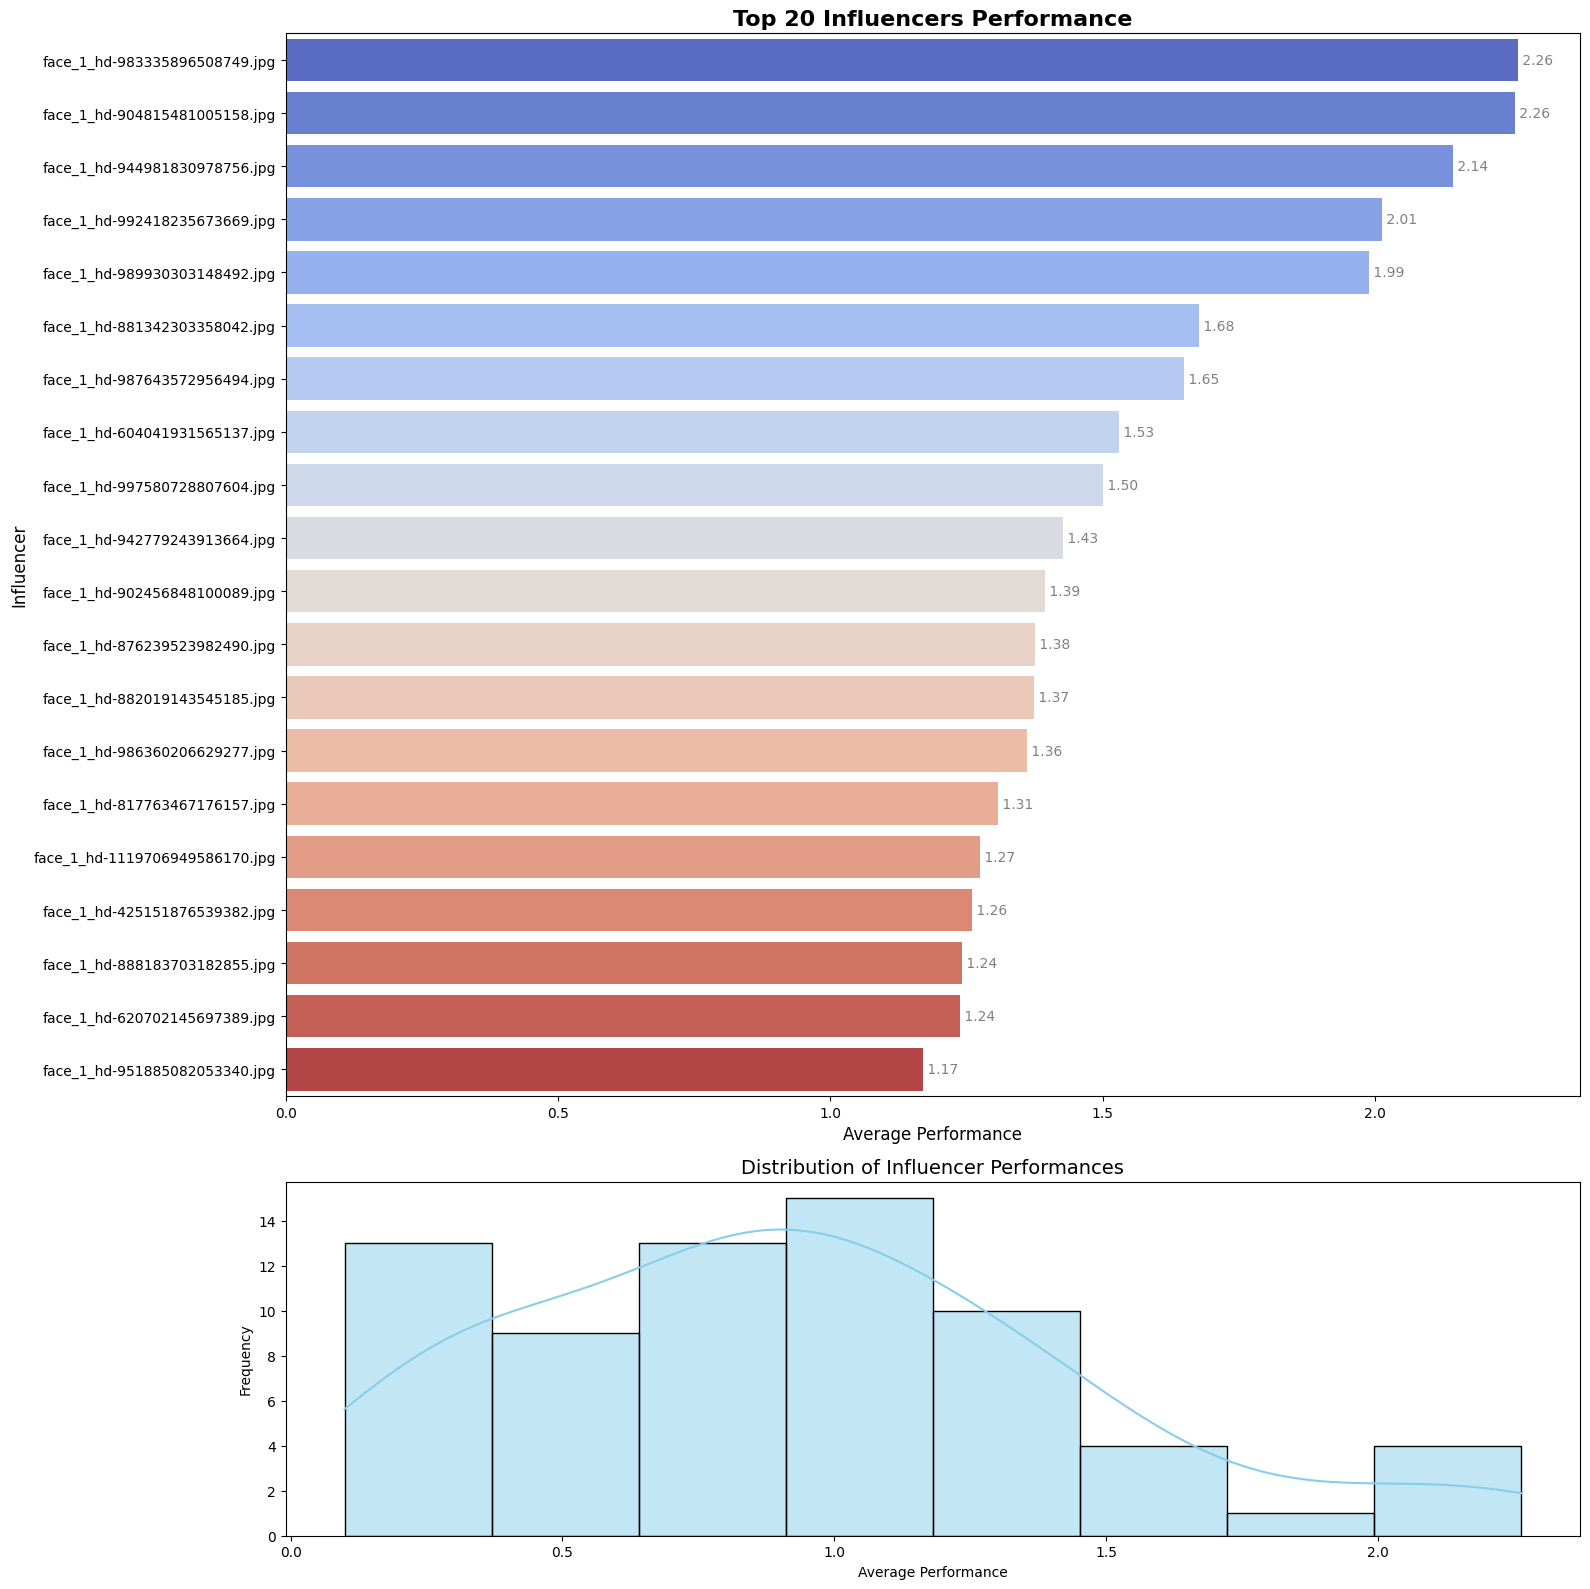

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

uploaded = files.upload()

file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

unique_data = data.drop_duplicates(subset=['Face Image']).reset_index(drop=True)

unique_data['Face Image Short'] = unique_data['Face Image'].apply(lambda x: x.split('/')[-1])

unique_data_sorted = unique_data.sort_values(by="Average Performance", ascending=False)

plt.figure(figsize=(16, 10))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16), gridspec_kw={'height_ratios': [3, 1]})

top_20_data = unique_data_sorted.head(20)

palette = sns.color_palette("coolwarm", n_colors=20)

sns.barplot(
    x="Average Performance",
    y="Face Image Short",
    data=top_20_data,
    palette=palette,
    ax=ax1,
    orient='h',
    hue="Face Image Short",
    legend=False
)

ax1.set_title("Top 20 Influencers Performance", fontsize=16, fontweight='bold')
ax1.set_xlabel("Average Performance", fontsize=12)
ax1.set_ylabel("Influencer", fontsize=12)

for i, v in enumerate(top_20_data['Average Performance']):
    ax1.text(v, i, f' {v:.2f}', va='center', fontsize=10, color='gray')

sns.histplot(
    unique_data_sorted['Average Performance'],
    kde=True,
    color='skyblue',
    ax=ax2
)
ax2.set_title("Distribution of Influencer Performances", fontsize=14)
ax2.set_xlabel("Average Performance", fontsize=10)
ax2.set_ylabel("Frequency", fontsize=10)

plt.tight_layout()

print("\nPerformance Insights:")
print(f"Total Influencers: {len(unique_data)}")
print(f"Mean Performance: {unique_data['Average Performance'].mean():.2f}")
print(f"Median Performance: {unique_data['Average Performance'].median():.2f}")
print(f"Top Performer: {top_20_data.iloc[0]['Face Image Short']} (Performance: {top_20_data.iloc[0]['Average Performance']:.2f})")
print(f"Bottom Performer: {unique_data_sorted.iloc[-1]['Face Image Short']} (Performance: {unique_data_sorted.iloc[-1]['Average Performance']:.2f})")

plt.savefig('influencer_performance.png', dpi=300, bbox_inches='tight')

plt.show()